In [ ]:
%pip install rank-bm25

In [2]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.document_loaders.merge import MergedDataLoader

from rank_bm25 import BM25Okapi
from collections import defaultdict

from langchain.docstore.document import Document
from langchain_community.vectorstores import FAISS

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [9]:
# Load evaluation data
eval_data = pd.read_csv('../../data/questions_answers/questions_answers.csv')
eval_data.rename(columns={eval_data.columns[0]: 'PMID'}, inplace=True)

gold_pmids = eval_data['PMID'].to_list()
eval_queries = eval_data['QUESTION'].to_list()

# Load abstracts data
df1 = pd.read_csv('../../data/processed_data_part1.csv', usecols=['PMID', 'Abstract'])
df2 = pd.read_csv('../../data/processed_data_part2.csv', usecols=['PMID', 'Abstract'])

# Merge the datasets
abstracts = pd.concat([df1, df2], ignore_index=True)

In [12]:
# Create corpus for BM25
corpus = abstracts['Abstract'].tolist()
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

print(tokenized_corpus[:10])
print(len(tokenized_corpus))

[['SUMMARY', 'Several', 'lines', 'of', 'evidence', 'support', 'the', 'involvement', 'of', 'inflammatory', 'and', 'immunologic', 'abnormalities', 'in', 'chronic', 'fatigue', 'syndrome', 'CFS', 'Since', 'recent', 'studies', 'have', 'shown', 'that', 'α1', 'antitrypsin', 'AAT', 'possesses', 'antiinflammatory', 'properties', 'the', 'potential', 'therapeutic', 'effect', 'of', 'AAT', 'treatment', 'on', 'CFS', 'has', 'been', 'investigated', 'A', '49yearold', 'woman', 'diagnosed', 'with', 'CFS', 'was', 'treated', 'with', 'intravenous', 'infusions', 'of', 'a', 'human', 'plasmaderived', 'AAT', 'concentrate', '60', 'mgkg', 'body', 'weight', 'weekly', 'for', '8', 'consecutive', 'weeks', 'The', 'patients', 'monocyte', 'elastase', 'a', 'regulator', 'of', 'inflammatory', 'processes', 'was', '1170', 'Umg', 'At', 'completion', 'of', 'treatment', 'improvement', 'in', 'maximal', 'workload', 'was', 'observed', '540717', 'of', 'predicted', 'Additionally', 'amelioration', 'in', 'working', 'memory', 'scores',

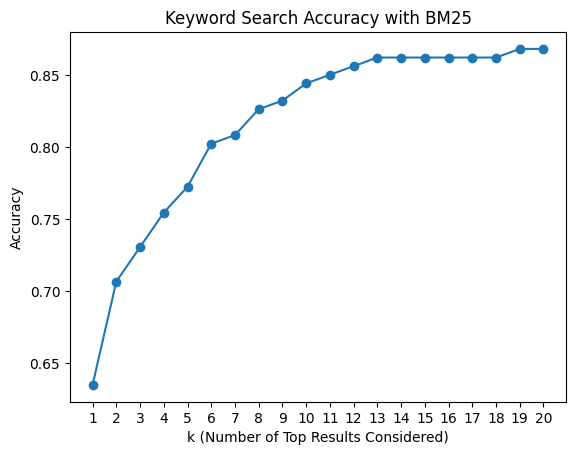

In [23]:
accuracies = []

# Evaluate BM25 for different values of k
for k in range(1, 21):
    matches = 0
    for query, gold_label in zip(eval_queries, gold_pmids):
        tokenized_query = query.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        
        # Get indices of top k documents
        top_k_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:k]
        
        # Convert indices to PMIDs
        retrieved_pmids = [int(abstracts['PMID'].iloc[i]) for i in top_k_indices]
        
        
        if gold_label in retrieved_pmids:
            matches += 1

    accuracy = matches / len(eval_queries)
    accuracies.append(accuracy)

# Save accuracies to a text file
file_path = './text_files/keyword_search_bm25_accuracies.txt'
with open(file_path, 'w') as f:
    for accuracy in accuracies:
        f.write(f"{accuracy}\n")

# Plotting the results
plot_title = "Keyword Search Accuracy with BM25"
file_name = './images/keyword_search_bm25_accuracies.png'

plt.plot(range(1, 21), accuracies, marker='o')
plt.xlabel('k (Number of Top Results Considered)')
plt.ylabel('Accuracy')
plt.title(plot_title)
plt.xticks(range(1, 21))

plt.savefig(file_name)


In [24]:
# Compute Mean Reciprocal Rank (MRR)

mrr = 0
for query, gold_label in zip(eval_queries, gold_pmids):
    tokenized_query = query.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)

    # Get indices of top k documents
    top_k_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:k]
    
    # Convert indices to PMIDs
    retrieved_pmids = [int(abstracts['PMID'].iloc[i]) for i in top_k_indices]

    for rank, pmid in enumerate(retrieved_pmids, start=1):
        if pmid == gold_label:
            mrr += 1 / rank
            break

mrr /= len(eval_queries)
print(mrr)

# Save MRRs to a text file
with open("./text_files/keyword_search_bm25_MRR.txt", 'w') as f:
    f.write(f"{mrr}")

0.6999965988068731


In [25]:
# Compute Normalized Discounted Cumulative Gain (nDCG)
ndcg_list = []

for k in range(1, 4):

    dcg_values = []
    for query, gold_label in zip(eval_queries, gold_pmids):
        tokenized_query = query.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)

        # Get indices of top k documents
        top_k_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:k]
        
        # Convert indices to PMIDs
        retrieved_pmids = [int(abstracts['PMID'].iloc[i]) for i in top_k_indices]

        # DCG calculation
        dcg = sum([1 / np.log2(rank + 1) if pmid == gold_label else 0 for rank, pmid in enumerate(retrieved_pmids, start=2)])
        dcg_values.append(dcg)

    # Assuming ideal DCG (iDCG) is the best case where the first document is always relevant
    idcg = 1 / np.log2(2)  # Best case for top-1 result being relevant
    ndcg = np.mean([dcg / idcg for dcg in dcg_values])

    ndcg_list.append(ndcg)

    print(ndcg)


# Save nDCGs to a text file
with open("./text_files/keyword_search_bm25_nDCG.txt", 'w') as f:
    for ndcg in ndcg_list:
        f.write(f"{ndcg}\n")

0.4004703825064342
0.43639852621900904
0.4467141324004077


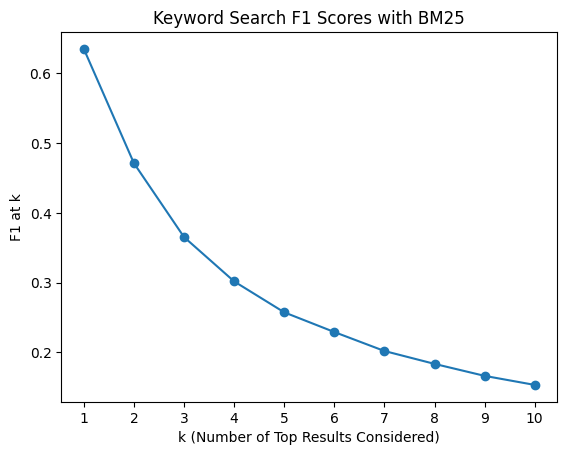

In [26]:
# Compute F1 at k
f1_list = []

for k in range(1, 11):

    precision_at_k = []
    recall_at_k = []

    for query, gold_label in zip(eval_queries, gold_pmids):
        tokenized_query = query.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)

        # Get indices of top k documents
        top_k_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:k]
        
        # Convert indices to PMIDs
        retrieved_pmids = [int(abstracts['PMID'].iloc[i]) for i in top_k_indices]

        true_positives = sum([1 for pmid in retrieved_pmids if pmid == gold_label])
        precision = true_positives / k
        recall = true_positives / 1  #assuming one relevant document per query
        precision_at_k.append(precision)
        recall_at_k.append(recall)

    mean_precision = np.mean(precision_at_k)
    mean_recall = np.mean(recall_at_k)
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0

    f1_list.append(f1_score)


# Save F1s to a text file
with open("./text_files/keyword_search_bm25_F1.txt", 'w') as f:
    for f1 in f1_list:
        f.write(f"{f1}\n")

# Plotting the results
plt.plot(range(1, 11), f1_list, marker='o')
plt.xlabel('k (Number of Top Results Considered)')
plt.ylabel('F1 at k')
plt.title(f'Keyword Search F1 Scores with BM25')
plt.xticks(range(1, 11))

plt.savefig("./images/keyword_search_bm25_F1.png")